# Correlate filtered tide gauges with the SWOT and CMEMS grids

The tide gauge time series are contained in filtered_sla_dac_filtered with shape (94,5). Their coordinates are contained 
in the arrays valid_latitudes an valid_longitues. Their names in valid_site_names
The time series from altimetry are contained in "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT"
with files of the kind "filtered_sla_lat_-26.20_lon_158.00.nc", containing latitude and longitude in their name. 
Create a map showing the correlation of the first tide gauges with all the time series from altimetry.

Processing tide gauge: Bermagui at lat: -36.42633887, lon: 150.0715333


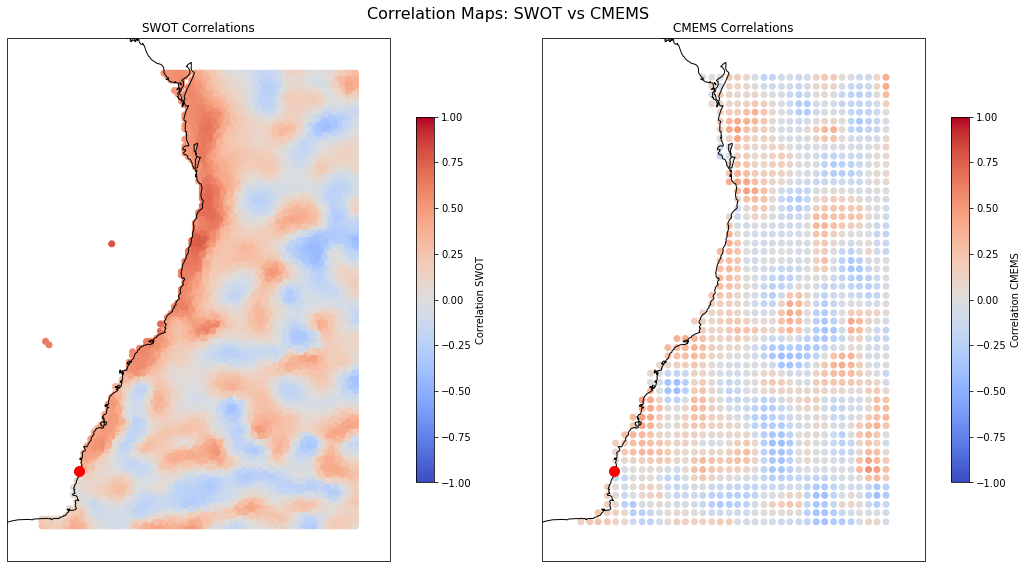

Processing tide gauge: Batemans_Bay_Princess_Jetty at lat: -35.7049, lon: 150.1779


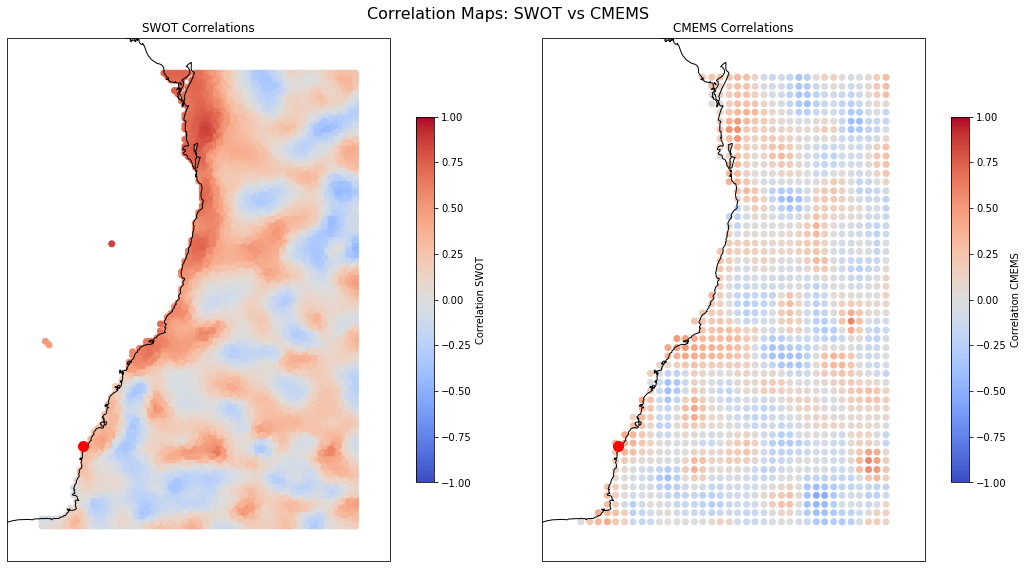

Processing tide gauge: Crookhaven_Heads at lat: -34.9066, lon: 150.7592


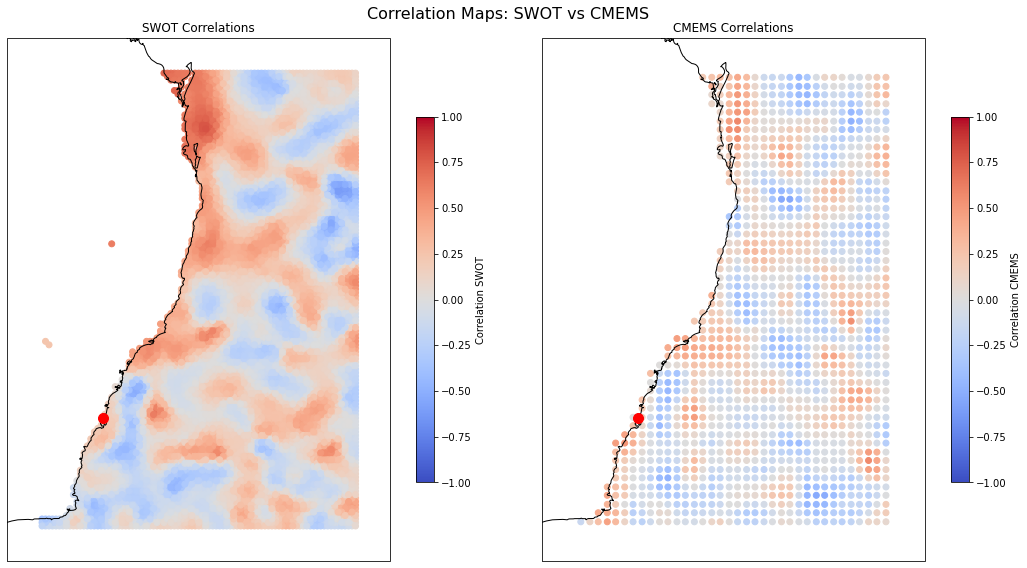

Processing tide gauge: Patonga at lat: -33.55098053, lon: 151.27462


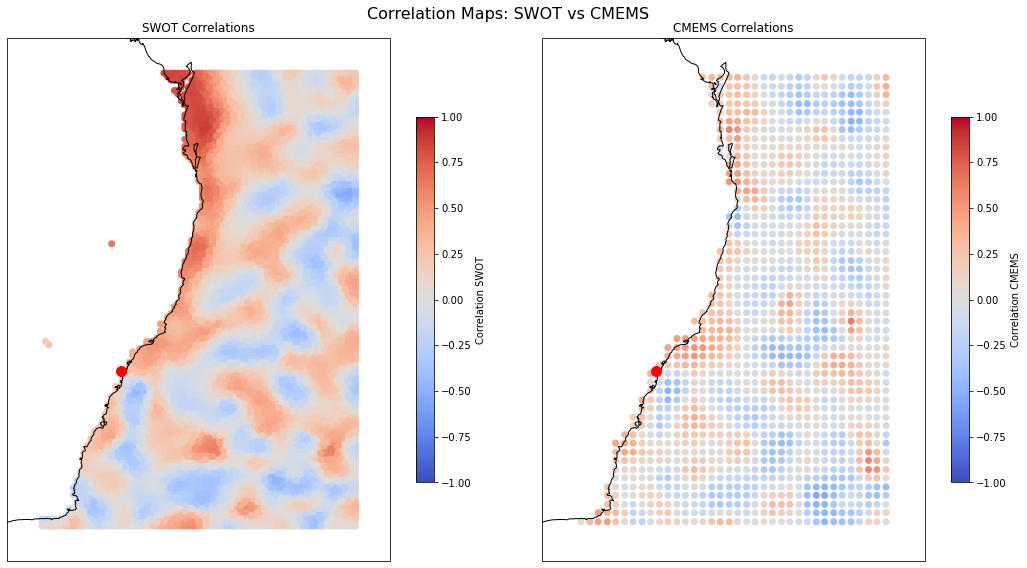

Processing tide gauge: Forster at lat: -32.17398888, lon: 152.5082112


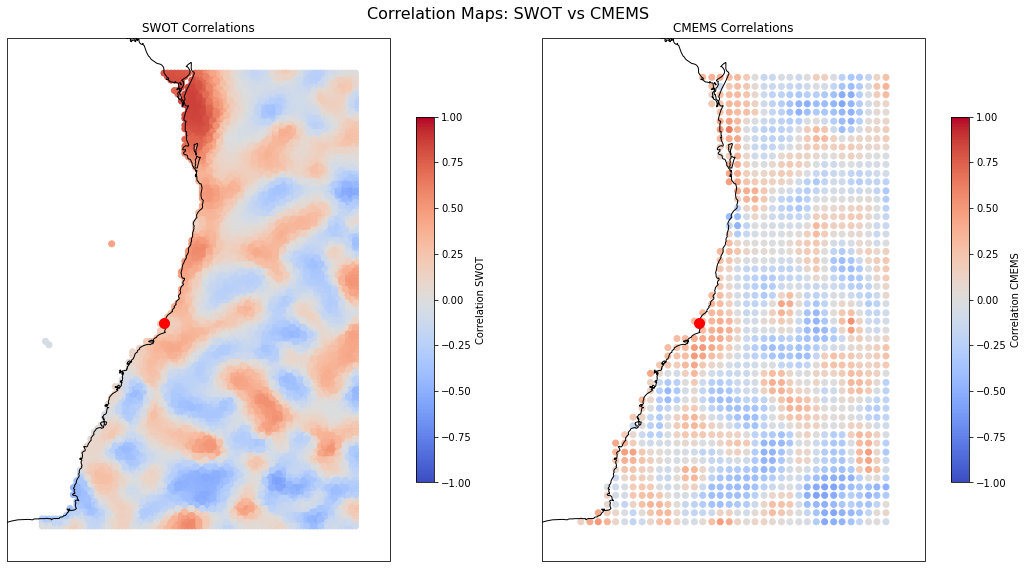

Processing tide gauge: Port_Macquarie at lat: -31.42679171, lon: 152.9109833


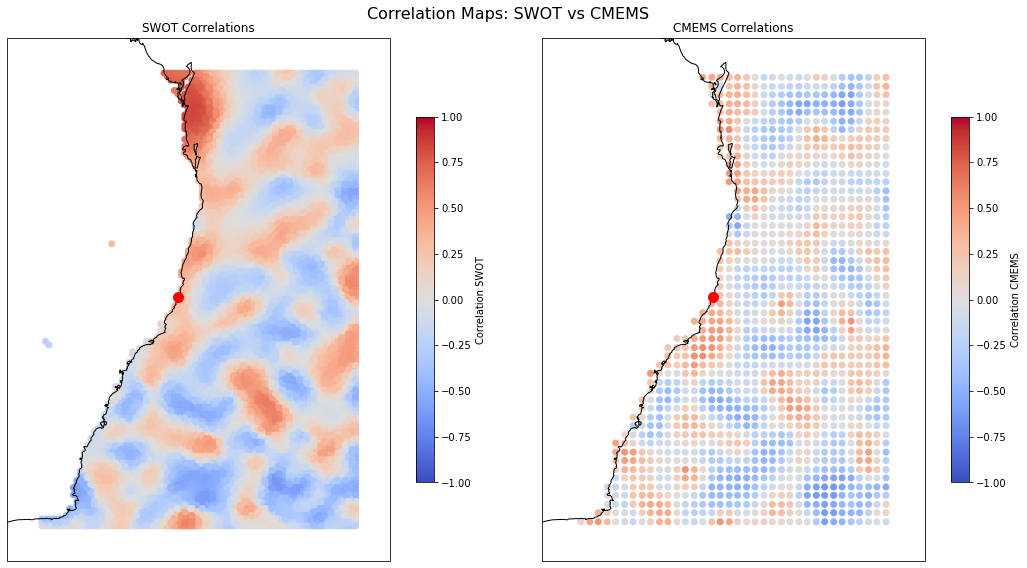

Processing tide gauge: Coffs_Harbour at lat: -30.30285837, lon: 153.1460611


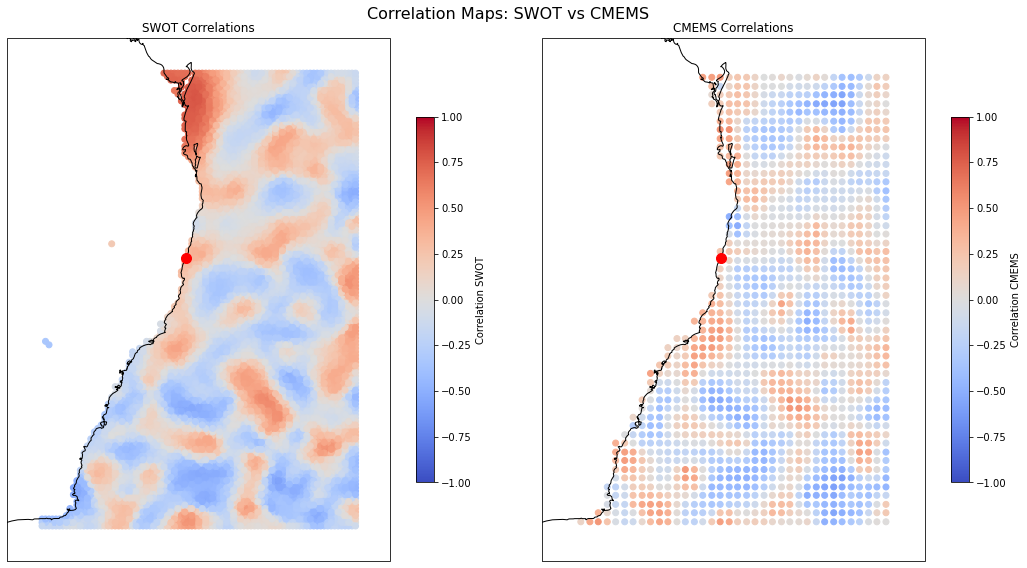

Processing tide gauge: Brunswick_Heads at lat: -28.53681115, lon: 153.55211


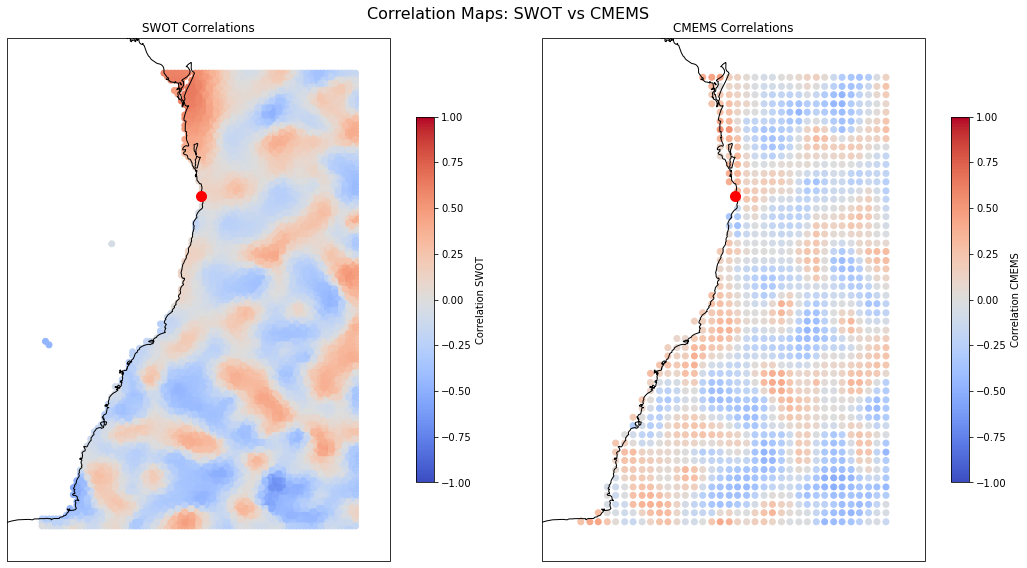

Total execution time: 459.49 seconds


In [10]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import re
import time

def load_tide_gauge_time_series(tide_gauge_data, valid_latitudes, valid_longitudes, valid_site_names):
    """
    Extract tide gauge time series and their coordinates.
    """
    # Return all tide gauge time series, latitudes, longitudes, and names
    return tide_gauge_data, valid_latitudes, valid_longitudes, valid_site_names

def extract_lat_lon_from_filename(file_name):
    """
    Extract latitude and longitude from the filename using regex.
    Example: 'filtered_sla_lat_-26.20_lon_158.00.nc' -> (-26.20, 158.00)
    """
    match = re.search(r'lat_([-+]?\d*\.\d+)_lon_([-+]?\d*\.\d+)', file_name)
    if match:
        lat = float(match.group(1))
        lon = float(match.group(2))
        return lat, lon
    return None, None

def compute_correlation(tide_gauge_ts, altimetry_ts, lag_days=0):
    """
    Compute the Pearson correlation coefficient between the tide gauge and altimetry time series,
    with an option to apply a time lag (in days).
    """
    if np.isnan(altimetry_ts).all() or np.isnan(tide_gauge_ts).all():
        return np.nan  # If the altimetry data or tide gauge data is all NaN, return NaN

    if lag_days != 0:
        # Apply lag by shifting the tide gauge time series
        tide_gauge_ts = np.roll(tide_gauge_ts, lag_days)

    return np.corrcoef(tide_gauge_ts, altimetry_ts)[0, 1]  # Pearson correlation coefficient

def plot_correlation_map(lats_SWOT, lons_SWOT, correlations_SWOT, 
                         lats_CMEMS, lons_CMEMS, correlations_CMEMS, 
                         tide_gauge_lat, tide_gauge_lon, tide_gauge_name):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set extent for both panels (so they have the same zoom level)
    extent = [min(np.min(lons_SWOT), np.min(lons_CMEMS)) - 1, max(np.max(lons_SWOT), np.max(lons_CMEMS)) + 1, 
              min(np.min(lats_SWOT), np.min(lats_CMEMS)) - 1, max(np.max(lats_SWOT), np.max(lats_CMEMS)) + 1]
    
    # Shared colorbar limits (-1 to +1)
    vmin, vmax = -1, 1
    
    # Panel 1: SWOT data
    ax1.coastlines()
    ax1.set_extent(extent, crs=ccrs.PlateCarree())
    sc_SWOT = ax1.scatter(lons_SWOT, lats_SWOT, c=correlations_SWOT, cmap='coolwarm', vmin=vmin, vmax=vmax, 
                          transform=ccrs.PlateCarree(), label="SWOT Data")
    cbar_SWOT = fig.colorbar(sc_SWOT, ax=ax1, orientation='vertical', shrink=0.7, label='Correlation SWOT')
    ax1.plot(tide_gauge_lon, tide_gauge_lat, 'ro', markersize=10, transform=ccrs.PlateCarree(), label=tide_gauge_name)
    ax1.set_title('SWOT Correlations')

    # Panel 2: CMEMS data (same scatter style as SWOT)
    ax2.coastlines()
    ax2.set_extent(extent, crs=ccrs.PlateCarree())
    sc_CMEMS = ax2.scatter(lons_CMEMS, lats_CMEMS, c=correlations_CMEMS, cmap='coolwarm', vmin=vmin, vmax=vmax, 
                           transform=ccrs.PlateCarree(), label="CMEMS Data", marker='o')  # Changed marker to 'o'
    cbar_CMEMS = fig.colorbar(sc_CMEMS, ax=ax2, orientation='vertical', shrink=0.7, label='Correlation CMEMS')
    ax2.plot(tide_gauge_lon, tide_gauge_lat, 'ro', markersize=10, transform=ccrs.PlateCarree(), label=tide_gauge_name)
    ax2.set_title('CMEMS Correlations')

    plt.suptitle('Correlation Maps: SWOT vs CMEMS', fontsize=16)
    plt.tight_layout()
    plt.show()

def process_altimetry_data(altimetry_data_dir, tide_gauge_ts, tide_gauge_lat, tide_gauge_lon, tide_gauge_name, lag_days=0):
    """
    Process the altimetry data directory and compute correlations with the tide gauge time series,
    with an option to compute lagged correlations.
    """
    altimetry_lats = []
    altimetry_lons = []
    correlations = []

    # Iterate over the altimetry files in the directory
    for file_name in os.listdir(altimetry_data_dir):
        if file_name.startswith('filtered_sla_lat') and file_name.endswith('.nc'):
            file_path = os.path.join(altimetry_data_dir, file_name)

            # Extract latitude and longitude from the filename
            altimetry_lat, altimetry_lon = extract_lat_lon_from_filename(file_name)
            if altimetry_lat is None or altimetry_lon is None:
                continue  # Skip files where lat/lon extraction failed

            # Load the altimetry time series
            altimetry_ds = xr.open_dataset(file_path)
            altimetry_ts = altimetry_ds['filtered_sla'].values

            # Compute correlation (with or without lag)
            corr = compute_correlation(tide_gauge_ts, altimetry_ts, lag_days)

            # Store the results
            altimetry_lats.append(altimetry_lat)
            altimetry_lons.append(altimetry_lon)
            correlations.append(corr)

            # Close the dataset after use
            altimetry_ds.close()

    # Convert results to numpy arrays for plotting
    altimetry_lats = np.array(altimetry_lats)
    altimetry_lons = np.array(altimetry_lons)
    correlations = np.array(correlations)

    return altimetry_lats, altimetry_lons, correlations

def main():
    start_time = time.time()  # Start timer

    # Paths to altimetry data and tide gauge data
    SWOT_dir = '/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT'
    CMEMS_dir = '/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_CMEMS'
    tide_gauge_data_path = '/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_time_series_tidegauges/tide_gauge_data.npz'

    # Load tide gauge data
    with np.load(tide_gauge_data_path) as data:
        tide_gauge_ts_data = data['filtered_sla_dac_filtered']  # Shape (time, n_gauges)
        tide_gauge_latitudes = data['valid_latitudes']
        tide_gauge_longitudes = data['valid_longitudes']
        tide_gauge_names = data['valid_site_names'].astype(str)  # Ensure names are strings

    # Number of days to lag (modify this value as needed)
    lag_days = 3  # Set to 0 for normal correlation, or any positive/negative integer for lagged correlation

    # Iterate over each tide gauge to compute and plot correlations
    for gauge_idx in range(len(tide_gauge_names)):
        tide_gauge_ts = tide_gauge_ts_data[:, gauge_idx]  # Get time series for this gauge
        tide_gauge_lat = tide_gauge_latitudes[gauge_idx]  # Get latitude for this gauge
        tide_gauge_lon = tide_gauge_longitudes[gauge_idx]  # Get longitude for this gauge
        tide_gauge_name = tide_gauge_names[gauge_idx]  # Get name for this gauge

        print(f"Processing tide gauge: {tide_gauge_name} at lat: {tide_gauge_lat}, lon: {tide_gauge_lon}")

        # Process altimetry data for SWOT
        altimetry_lats_SWOT, altimetry_lons_SWOT, correlations_SWOT = process_altimetry_data(
            SWOT_dir, tide_gauge_ts, tide_gauge_lat, tide_gauge_lon, tide_gauge_name, lag_days)

        # Process altimetry data for CMEMS
        altimetry_lats_CMEMS, altimetry_lons_CMEMS, correlations_CMEMS = process_altimetry_data(
            CMEMS_dir, tide_gauge_ts, tide_gauge_lat, tide_gauge_lon, tide_gauge_name, lag_days)

        # Plot comparison of correlations for SWOT and CMEMS
        plot_correlation_map(altimetry_lats_SWOT, altimetry_lons_SWOT, correlations_SWOT,
                             altimetry_lats_CMEMS, altimetry_lons_CMEMS, correlations_CMEMS,
                             tide_gauge_lat, tide_gauge_lon, tide_gauge_name)

    # End timer and print elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total execution time: {elapsed_time:.2f} seconds")

if __name__ == "__main__":
    main()
